In [34]:
!pip install osmnx networkx geopandas shapely matplotlib pandas

In [35]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import display, Markdown

# Ignorar avisos futuros do OSMnx
warnings.filterwarnings("ignore", category=FutureWarning)
ox.settings.log_console = False
ox.settings.use_cache = True

In [36]:
def processar_cidade(nome_cidade, tags_poi):
    """
    Executa o pipeline completo do desafio A* + MST para uma única cidade.
    """
    print(f"\n--- Iniciando processamento para: {nome_cidade} ---")

    try:
        # 1. Obter Grafo (Direcionado) e PROJETAR para UTM
        G_unproj = ox.graph_from_place(nome_cidade, network_type='drive')
        G = ox.project_graph(G_unproj)
        G = ox.routing.add_edge_speeds(G)
        G = ox.routing.add_edge_travel_times(G)
        print(f"Grafo de {nome_cidade} obtido e projetado para UTM (CRS: {G.graph['crs']}).")

        # Configuração de tags para uso genérico
        chave_poi = list(tags_poi.keys())[0]
        valor_poi = tags_poi[chave_poi]

        # 2. Obter POIs
        pois = ox.features.features_from_place(nome_cidade, tags=tags_poi)

        # 1. Filtra POIs sem nome (NaN)
        pois_limpos = pois.loc[pois['name'].notna()].copy() # Já remove os NaN.

        pois = pois_limpos

        # Detalhes e Depuração dos POIs
        print(f"\n--- Detalhes dos POIs ({valor_poi}) encontrados em {nome_cidade} ---")
        poi_details = []
        for idx, row in pois.iterrows():
            nome = row.get('name', 'Nome não disponível')
            geom = row.geometry
            lat, lon = (None, None)

            if geom.geom_type == 'Point':
                lat, lon = geom.y, geom.x
            elif geom.geom_type in ['Polygon', 'MultiPolygon']:
                lat, lon = geom.centroid.y, geom.centroid.x

            if lat is not None:
                poi_details.append({'Nome': nome, 'Latitude': lat, 'Longitude': lon})

        if poi_details:
            df_detalhes = pd.DataFrame(poi_details)
            display(df_detalhes)
        else:
            print("Nenhum POI com geometria válida (Ponto/Polígono) foi encontrado.")
            return None


        # Projetar os POIs para o mesmo CRS (UTM) do grafo
        pois_proj = pois.to_crs(G.graph['crs'])

        poi_pontos = []
        for idx, row in pois_proj.iterrows():
            if row.geometry.geom_type == 'Point':
                poi_pontos.append((row.geometry.y, row.geometry.x)) # y, x em metros
            elif row.geometry.geom_type in ['Polygon', 'MultiPolygon']:
                centroid = row.geometry.centroid
                poi_pontos.append((centroid.y, centroid.x)) # y, x do centroide em metros

        if len(poi_pontos) < 2:
            print(f"POIs insuficientes ({len(poi_pontos)}) para {nome_cidade}. Pulando.")
            return None

        ys_poi = [p[0] for p in poi_pontos]
        xs_poi = [p[1] for p in poi_pontos]

        nos_poi = ox.distance.nearest_nodes(G, X=xs_poi, Y=ys_poi)
        nos_poi = list(set(nos_poi))

        # --- FILTRAGEM DE NÓS ISOLADOS PARA GARANTIR CONECTIVIDADE ---
        try:
             # Encontra o maior componente fracamente conexo no grafo direcionado
             maior_componente = max(nx.weakly_connected_components(G), key=len)
        except ValueError:
             print("Aviso: Grafo sem componentes. Pulando.")
             return None

        nos_poi_filtrados = [n for n in nos_poi if n in maior_componente]

        num_isolados = len(nos_poi) - len(nos_poi_filtrados)
        if num_isolados > 0:
          print(f"  Aviso: Removendo {num_isolados} POI(s) isolado(s) para garantir a conectividade do MST.")

        nos_poi = nos_poi_filtrados

        num_pois = len(nos_poi)
        if num_pois < 2:
            print(f"Nós de POI únicos insuficientes ({num_pois}) para {nome_cidade}. Pulando.")
            return None

        print(f"Encontrados {num_pois} POIs únicos para roteamento.")

        # 3. Calcular rotas A* e 4. Construir Grafo Completo
        def heuristica_euclidiana_utm(u, v):
            node_u = G.nodes[u]
            node_v = G.nodes[v]
            return ((node_u['x'] - node_v['x'])**2 + (node_u['y'] - node_v['y'])**2)**0.5

        G_poi = nx.Graph()
        num_rotas = num_pois * (num_pois - 1) / 2
        print(f"Calculando {int(num_rotas)} rotas A* entre pares de POIs...")

        for i in range(num_pois):
            for j in range(i + 1, num_pois):
                u = nos_poi[i]
                v = nos_poi[j]
                try:
                    # Cálculo A* do comprimento (weight='length')
                    comprimento = nx.astar_path_length(G, u, v,
                                                       heuristic=heuristica_euclidiana_utm,
                                                       weight='length')
                    rota = nx.astar_path(G, u, v,
                                         heuristic=heuristica_euclidiana_utm,
                                         weight='length')

                    G_poi.add_edge(u, v, weight=comprimento, path=rota)

                except nx.NetworkXNoPath:
                    print(f"  Aviso: Sem rota entre nós {u} e {v} em {nome_cidade}. Par ignorado na MST.")
                    continue

        # 4. Calcular MST
        print("Calculando MST sobre o grafo de POIs...")

        # O MST só pode ser calculado se o grafo de POIs tiver arestas
        if not G_poi.edges:
             print(f"Não foi possível gerar MST para {nome_cidade} (grafo de POIs sem arestas).")
             return None

        mst_edges = list(nx.minimum_spanning_edges(G_poi, data=True))

        comprimento_total_m = sum([d['weight'] for (u, v, d) in mst_edges])
        comprimento_total_km = comprimento_total_m / 1000.0

        # 6. Visualização
        rotas_mst = [d['path'] for (u, v, d) in mst_edges]

        print(f"Plotando MST para {nome_cidade}...")
        fig, ax = ox.plot_graph_routes(
            G,
            routes=rotas_mst,
            route_colors='r',
            route_linewidth=2,
            node_size=0,
            edge_color='#444444',
            edge_linewidth=0.3,
            bgcolor='k',
            show=False, close=False
        )

        x_poi = [G.nodes[n]['x'] for n in nos_poi]
        y_poi = [G.nodes[n]['y'] for n in nos_poi]
        ax.scatter(x_poi, y_poi, c='cyan', s=50, zorder=5, edgecolor='w', alpha=0.8)

        # Uso da variável valor_poi para o título
        titulo = f"MST (A*) para POIs ({valor_poi}) em {nome_cidade}\nTotal: {comprimento_total_km:.2f} km"
        ax.set_title(titulo, fontsize=14, color='w')
        plt.show()

        # 5. Retornar métricas
        return {
            "Cidade": nome_cidade,
            "POIs Encontrados": num_pois,
            "Arestas na MST": len(mst_edges),
            "Comprimento Total MST (km)": f"{comprimento_total_km:.2f}"
        }

    except Exception as e:
        print(f"Erro ao processar {nome_cidade}: {e}")
        return None


--- Iniciando processamento para: Natal, Brazil ---
Grafo de Natal, Brazil obtido e projetado para UTM (CRS: EPSG:32725).

--- Detalhes dos POIs (bus_station) encontrados em Natal, Brazil ---


,Nome,Latitude,Longitude
0,Terminal do Circular Direto,-5.833182,-35.202939
1,Terminal do Circular Inverso,-5.833167,-35.203098
2,Parada das Mangueiras,-5.769847,-35.268967
3,Terminal Cidade Nova,-5.837038,-35.242261
4,Complexo Rodoviário Severino Tomaz da Silveira,-5.819384,-35.234842
5,Terminal Rocas,-5.773057,-35.203847
6,Conceição Transportes,-5.827631,-35.260540
7,Terminal Parque das Dunas,-5.729219,-35.236119
8,Terminal Nova Natal,-5.732863,-35.255642
9,Terminal Gramoré,-5.723538,-35.249953


Encontrados 23 POIs únicos para roteamento.
Calculando 253 rotas A* entre pares de POIs...
Calculando MST sobre o grafo de POIs...
Plotando MST para Natal, Brazil...


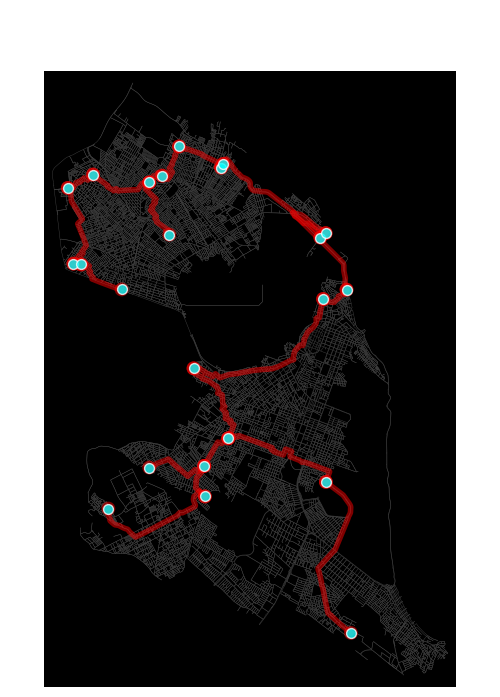


--- Iniciando processamento para: Aracaju, Brazil ---
Grafo de Aracaju, Brazil obtido e projetado para UTM (CRS: EPSG:32724).

--- Detalhes dos POIs (bus_station) encontrados em Aracaju, Brazil ---


,Nome,Latitude,Longitude
0,Terminal do DIA,-10.948407,-37.073885
1,Terminal do Centro,-10.908814,-37.052239
2,Rodoviária Praça João XXIII,-10.908436,-37.052017
3,Rodoviária de Aracaju,-10.916590,-37.088602
4,Terminal Zona Norte Leonel Brizola,-10.916934,-37.087681
5,Terminal Rodoviario D.I.A.,-10.948419,-37.073905
6,Terminal Zona Sul,-10.987906,-37.052453
7,Final de Linha do Bugio,-10.891401,-37.097467
8,Terminal Maracaju,-10.889037,-37.079039
9,Terminal Mercado,-10.903769,-37.048942


Encontrados 8 POIs únicos para roteamento.
Calculando 28 rotas A* entre pares de POIs...
  Aviso: Sem rota entre nós 3362287324 e 980026173 em Aracaju, Brazil. Par ignorado na MST.
Calculando MST sobre o grafo de POIs...
Plotando MST para Aracaju, Brazil...


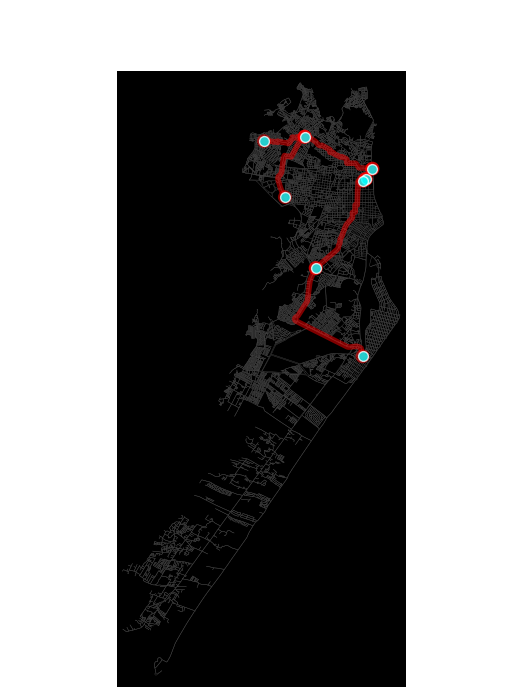


--- Iniciando processamento para: Fortaleza, Brazil ---
Grafo de Fortaleza, Brazil obtido e projetado para UTM (CRS: EPSG:32724).

--- Detalhes dos POIs (bus_station) encontrados em Fortaleza, Brazil ---


,Nome,Latitude,Longitude
0,Terminal Conjunto Ceará,-3.772865,-38.607561
1,Terminal de Integração do Conjunto Ceará,-3.772864,-38.607635
2,Terminal Sagrado Coração de Jesus,-3.732298,-38.526744
3,Terminal Parangaba,-3.776362,-38.563325
4,Terminal Rodoviário Antonio Bezerra,-3.739343,-38.596530
5,Terminal Antônio Bezerra,-3.737520,-38.584172
6,Terminal Lagoa,-3.771361,-38.570303
7,Terminal Messejana,-3.831175,-38.501871
8,Terminal Rodoviário de Messejana,-3.831168,-38.500444
9,Terminal José de Alencar,-3.726387,-38.532084


Encontrados 18 POIs únicos para roteamento.
Calculando 153 rotas A* entre pares de POIs...
Calculando MST sobre o grafo de POIs...
Plotando MST para Fortaleza, Brazil...


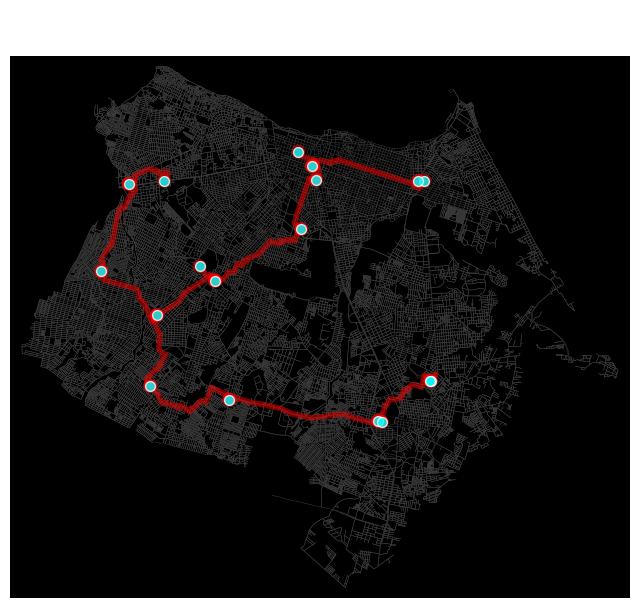


--- Iniciando processamento para: São Luís, Brazil ---
Grafo de São Luís, Brazil obtido e projetado para UTM (CRS: EPSG:32723).

--- Detalhes dos POIs (bus_station) encontrados em São Luís, Brazil ---


,Nome,Latitude,Longitude
0,Terminal da Fonte do Bispo,-2.537092,-44.301483
1,Terminal Praia Grande,-2.531533,-44.307567
2,Terminal Rodoviario do São Luís,-2.563558,-44.244814
3,Terminal Cohab / Cohatrac,-2.543411,-44.216954
4,TCV - Terminal de Integração Cohama / Vinhais,-2.519845,-44.246431
5,Terminal de Integração São Cristóvão,-2.569876,-44.223378
6,Terminal de Integração Cohama / Vinhais,-2.519715,-44.246860
7,Terminal de Integração Distrito Industrial,-2.638516,-44.269672
8,Terminal de Integração Cohab / Cohatrac,-2.543384,-44.216947
9,Terminal de Integração do São Cristóvão,-2.569893,-44.223380


Encontrados 7 POIs únicos para roteamento.
Calculando 21 rotas A* entre pares de POIs...
Calculando MST sobre o grafo de POIs...
Plotando MST para São Luís, Brazil...


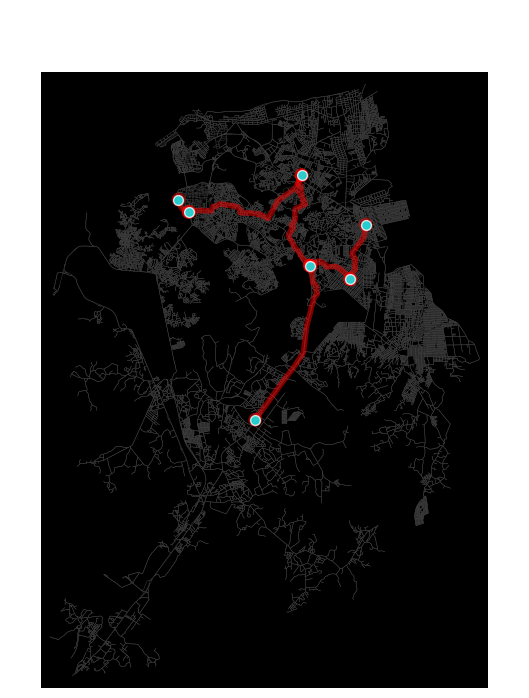


--- Iniciando processamento para: João Pessoa, Brazil ---
Grafo de João Pessoa, Brazil obtido e projetado para UTM (CRS: EPSG:32725).

--- Detalhes dos POIs (bus_station) encontrados em João Pessoa, Brazil ---


,Nome,Latitude,Longitude
0,Terminal do Varadouro | Plataforma C - 02,-7.117665,-34.890053
1,Terminal de Ônibus de Mangabeira IV,-7.188800,-34.839088
2,Terminal de Ônibus de Muçumagro,-7.216093,-34.831654
3,Terminal Miramar - Linha 402,-7.124590,-34.836755
4,"Terminal Cristo Redentor - 204, 208, 3200",-7.166489,-34.872002
5,Terminal Quadramares - Linha 203,-7.160767,-34.821127
6,Terminal de Ônibus do Val Paraíso,-7.081084,-34.846019
7,Terminal 5100 Circular,-7.180503,-34.865761
8,Terminal 1510 - 5110,-7.179756,-34.871189
9,Terminal 502-202-106,-7.176377,-34.866754


Encontrados 19 POIs únicos para roteamento.
Calculando 171 rotas A* entre pares de POIs...
Calculando MST sobre o grafo de POIs...
Plotando MST para João Pessoa, Brazil...


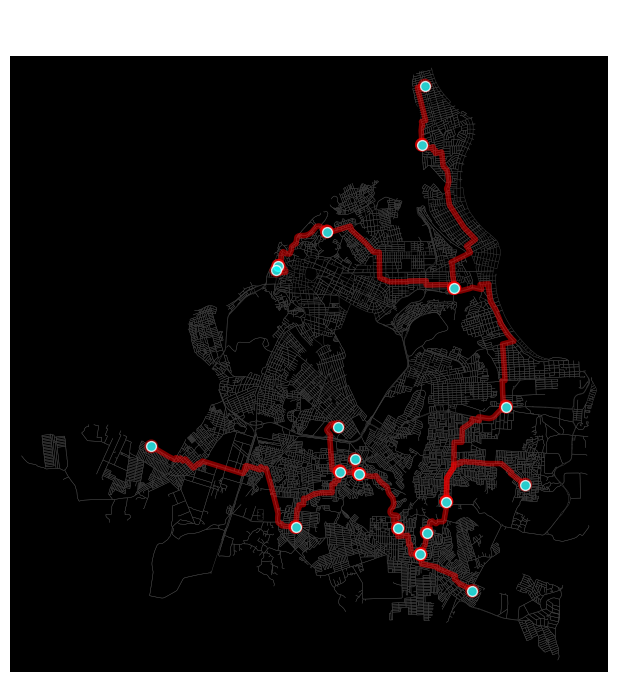


--- Iniciando processamento para: Campina Grande, Brazil ---
Grafo de Campina Grande, Brazil obtido e projetado para UTM (CRS: EPSG:32725).

--- Detalhes dos POIs (bus_station) encontrados em Campina Grande, Brazil ---


,Nome,Latitude,Longitude
0,Terminal Rodoviário de Campina Grande,-7.238043,-35.869763
1,Rodoviária Velha,-7.216775,-35.882563
2,Terminal de Integração,-7.220701,-35.889337
3,Terminal Rodoviário de Campina Grande,-7.238782,-35.871164


Encontrados 4 POIs únicos para roteamento.
Calculando 6 rotas A* entre pares de POIs...
Calculando MST sobre o grafo de POIs...
Plotando MST para Campina Grande, Brazil...


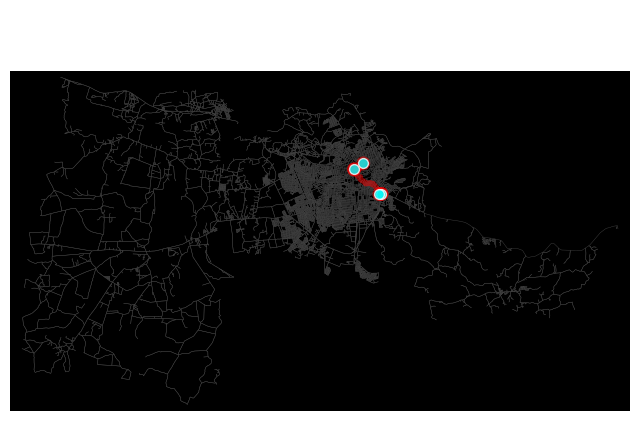


--- Iniciando processamento para: Mossoró, Brazil ---
Grafo de Mossoró, Brazil obtido e projetado para UTM (CRS: EPSG:32724).

--- Detalhes dos POIs (bus_station) encontrados em Mossoró, Brazil ---


,Nome,Latitude,Longitude
0,Terminal Rodoviário de Mossoró,-5.185156,-37.373809
1,Terminal do Carcará,-5.194803,-37.342853
2,Terminal Praça Felipe Guerra,-5.194409,-37.344734


Encontrados 3 POIs únicos para roteamento.
Calculando 3 rotas A* entre pares de POIs...
Calculando MST sobre o grafo de POIs...
Plotando MST para Mossoró, Brazil...


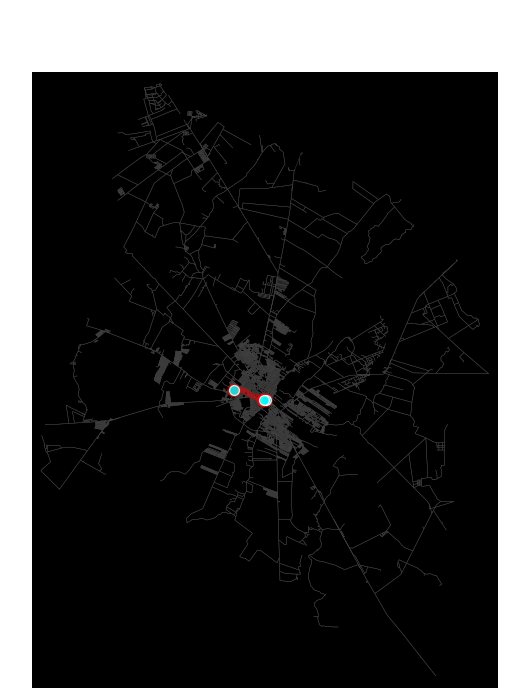


--- Iniciando processamento para: Maceió, Brazil ---
Grafo de Maceió, Brazil obtido e projetado para UTM (CRS: EPSG:32725).

--- Detalhes dos POIs (bus_station) encontrados em Maceió, Brazil ---


,Nome,Latitude,Longitude
0,Terminal de Cruz das Almas,-9.630239,-35.696884
1,Terminal do Conjunto Frei Damião,-9.554504,-35.715936
2,Terminal do Eustáquio Gomes,-9.541870,-35.783226
3,Terminal Quadra C - 53,-9.564523,-35.729948
4,Terminal do Trapiche,-9.674374,-35.761133
5,Terminal Graciliano Ramos,-9.548065,-35.747763
6,Terminal Vergel do Lago,-9.652434,-35.760947
7,Terminal José Tenório,-9.609697,-35.709406
8,Terminal Novo Mundo,-9.621335,-35.726262
9,Terminal de Fernão Velho,-9.589998,-35.784970


Encontrados 24 POIs únicos para roteamento.
Calculando 276 rotas A* entre pares de POIs...
Calculando MST sobre o grafo de POIs...
Plotando MST para Maceió, Brazil...


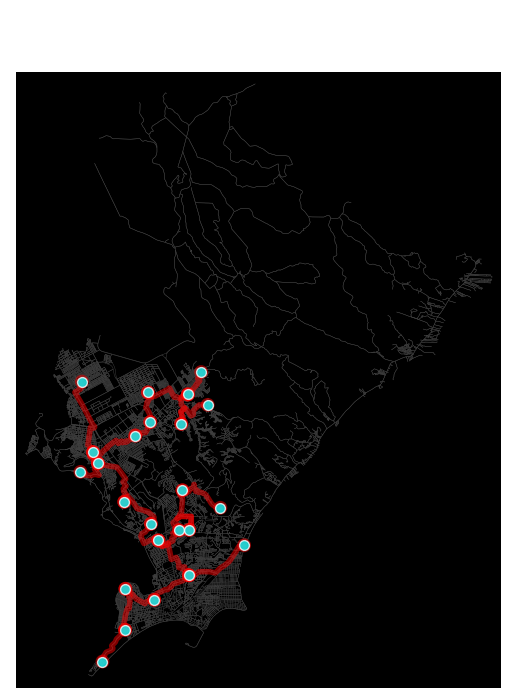

In [37]:
# 1. Escolha de POIs
POI_TAGS = {
    'amenity': 'bus_station'
    }

# 5. Lista de Cidades
CIDADES = [
    "Natal, Brazil",
    "Aracaju, Brazil",
    "Fortaleza, Brazil",
    "São Luís, Brazil",
   "João Pessoa, Brazil",
    "Campina Grande, Brazil",
    "Mossoró, Brazil",
    "Maceió, Brazil",
]

resultados = []
for cidade in CIDADES:
    resultado = processar_cidade(cidade, POI_TAGS)
    if resultado:
        resultados.append(resultado)

In [33]:
# 7. Tabela Comparativa
display(Markdown("## Tabela Comparativa de Resultados"))

if not resultados:
    display(Markdown("Nenhum resultado foi gerado."))
else:
    df_resultados = pd.DataFrame(resultados)

    # Converter colunas numéricas
    df_resultados['Comprimento Total MST (km)'] = pd.to_numeric(df_resultados['Comprimento Total MST (km)'])
    df_resultados['POIs Encontrados'] = pd.to_numeric(df_resultados['POIs Encontrados'])
    df_resultados['Arestas na MST'] = pd.to_numeric(df_resultados['Arestas na MST'])

    # Calcular Métricas Adicionais
    # Média e Desvio Padrão por POI (km/POI)
    df_resultados['km/POI'] = df_resultados['Comprimento Total MST (km)'] / df_resultados['POIs Encontrados']
    # Média e Desvio Padrão por aresta da MST (km/aresta-MST)
    df_resultados['km/Aresta MST'] = df_resultados['Comprimento Total MST (km)'] / df_resultados['Arestas na MST']

    # Arredondar para exibição
    df_final = df_resultados.round(2)

    # Exibir a tabela em Markdown
    display(Markdown(df_final.to_markdown(index=False)))

    # Exibir Médias e Desvios Padrão consolidados
    display(Markdown("### Métricas Consolidadas (km/POI)"))
    display(Markdown(f"- **Média (km/POI):** {df_final['km/POI'].mean():.2f} km"))
    display(Markdown(f"- **Desvio Padrão (km/POI):** {df_final['km/POI'].std():.2f} km"))

    display(Markdown("### Métricas Consolidadas (km/Aresta MST)"))
    display(Markdown(f"- **Média (km/Aresta MST):** {df_final['km/Aresta MST'].mean():.2f} km"))
    display(Markdown(f"- **Desvio Padrão (km/Aresta MST):** {df_final['km/Aresta MST'].std():.2f} km"))

## Tabela Comparativa de Resultados

| Cidade                 |   POIs Encontrados |   Arestas na MST |   Comprimento Total MST (km) |   km/POI |   km/Aresta MST |
|:-----------------------|-------------------:|-----------------:|-----------------------------:|---------:|----------------:|
| Natal, Brazil          |                  5 |                4 |                        19.85 |     3.97 |            4.96 |
| Aracaju, Brazil        |                  2 |                1 |                         5.73 |     2.86 |            5.73 |
| Fortaleza, Brazil      |                 17 |               16 |                        64.28 |     3.78 |            4.02 |
| São Luís, Brazil       |                  7 |                6 |                        23.21 |     3.32 |            3.87 |
| João Pessoa, Brazil    |                 11 |               10 |                        35.23 |     3.2  |            3.52 |
| Campina Grande, Brazil |                  3 |                2 |                         6.51 |     2.17 |            3.26 |
| Mossoró, Brazil        |                  3 |                2 |                         5.44 |     1.81 |            2.72 |
| Maceió, Brazil         |                  6 |                5 |                        28.5  |     4.75 |            5.7  |

### Métricas Consolidadas (km/POI)

- **Média (km/POI):** 3.23 km

- **Desvio Padrão (km/POI):** 0.96 km

### Métricas Consolidadas (km/Aresta MST)

- **Média (km/Aresta MST):** 4.22 km

- **Desvio Padrão (km/Aresta MST):** 1.12 km